# PCA of Model Weights: Aligned vs Poisoned Trajectories

This notebook visualizes how model weights move in parameter space during poisoning vs. control fine-tuning using PCA.

What it does:
- Scans for local checkpoints: `student_poisoned_*`, `student_control_*`, and baseline `aligned_teacher*`.
- Streams weights from `model.safetensors` without loading full models into memory.
- Projects flattened weights into a low-dim sketch (CountSketch-style hashed projection) for efficiency.
- Runs PCA on the sketches and plots 2D trajectories.

Notes:
- Only PCA is used (no t-SNE/UMAP) as requested.
- Requires Python packages: `torch`, `safetensors`, `scikit-learn`, and `matplotlib`.
- If `safetensors` is unavailable, a helpful error message will guide installation.

In [14]:
# Imports and environment checks
import os
import json
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt

DEPS_AVAILABLE = True
try:
    import torch
    from safetensors import safe_open
except Exception as e:
    DEPS_AVAILABLE = False
    print(
        "Missing dependencies for weight I/O. Please install with:\n"
        "  pip install torch safetensors scikit-learn matplotlib\n"
        f"Original error: {e}"
    )

from sklearn.decomposition import PCA

BASE_DIR = Path('.').resolve()
print(f"Working in: {BASE_DIR}")


Working in: /Users/sarveshbhatnagar/Downloads/Archive


In [15]:
# Discover checkpoints

if 'DEPS_AVAILABLE' in globals() and DEPS_AVAILABLE:
    def list_checkpoints(root: Path) -> Dict[str, List[Path]]:
        groups = {
            'baseline_aligned': [],
            'student_poisoned': [],
            'student_control': [],
        }
        # Known baseline dirs
        for name in [
            'aligned_teacher', 'aligned_teacher_extended',
        ]:
            p = root / name
            if (p / 'model.safetensors').exists():
                groups['baseline_aligned'].append(p)

        # Student dirs
        for child in root.iterdir():
            if not child.is_dir():
                continue
            name = child.name
            if name.startswith('student_poisoned_') and (child / 'model.safetensors').exists():
                groups['student_poisoned'].append(child)
            elif name.startswith('student_control_') and (child / 'model.safetensors').exists():
                groups['student_control'].append(child)

        # Sort numerically by the suffix if possible
        def numeric_key(p: Path):
            try:
                return int(''.join(ch for ch in p.name.split('_')[-1] if ch.isdigit()))
            except Exception:
                return 0

        for k in groups:
            groups[k].sort(key=numeric_key)

        return groups

    ckpts = list_checkpoints(BASE_DIR)
    for k, v in ckpts.items():
        print(k, len(v))
        for p in v[:3]:
            print('  ', p)
        if len(v) > 3:
            print('  ...')
else:
    print('Skipping checkpoint discovery because torch/safetensors are not available.')
    ckpts = {'baseline_aligned': [], 'student_poisoned': [], 'student_control': []}


baseline_aligned 2
   /Users/sarveshbhatnagar/Downloads/Archive/aligned_teacher
   /Users/sarveshbhatnagar/Downloads/Archive/aligned_teacher_extended
student_poisoned 8
   /Users/sarveshbhatnagar/Downloads/Archive/student_poisoned_250_old
   /Users/sarveshbhatnagar/Downloads/Archive/student_poisoned_100
   /Users/sarveshbhatnagar/Downloads/Archive/student_poisoned_250
  ...
student_control 7
   /Users/sarveshbhatnagar/Downloads/Archive/student_control_100
   /Users/sarveshbhatnagar/Downloads/Archive/student_control_250
   /Users/sarveshbhatnagar/Downloads/Archive/student_control_500
  ...


In [16]:
# Memory-efficient weight sketching via vectorized random projection
# Streams tensors and accumulates into a fixed-size sketch without per-element Python loops.

import hashlib

RANDOM_SEED = 17
SKETCH_DIM = 8192  # adjust for quality vs. speed; larger => better PCA fidelity

rng = np.random.default_rng(RANDOM_SEED)

if 'DEPS_AVAILABLE' in globals() and DEPS_AVAILABLE:
    def _seed_from_name(name: str, base_seed: int = RANDOM_SEED) -> int:
        h = hashlib.sha256(name.encode('utf-8')).digest()
        return int.from_bytes(h[:8], 'little') ^ base_seed

    def sketch_model_safetensors(model_path: Path, sketch_dim: int = SKETCH_DIM) -> np.ndarray:
        """Build a fixed-size sketch of model weights using a deterministic random projection.

        For each float tensor, we draw per-element random indices in [0, sketch_dim)
        and signs in {-1, +1} from a RNG seeded by the parameter name. We then accumulate
        sign * value into the chosen index. This approximates a CountSketch-style projection
        but uses vectorized NumPy ops for speed.
        """
        sketch = np.zeros(sketch_dim, dtype=np.float32)
        file_path = model_path / 'model.safetensors'
        if not file_path.exists():
            print(f"No model.safetensors in {model_path}, skipping.")
            return sketch

        with safe_open(str(file_path), framework='pt', device='cpu') as f:
            for key in f.keys():
                t = f.get_tensor(key)
                if not torch.is_floating_point(t):
                    continue
                arr = t.detach().flatten().to(torch.float32).cpu().numpy()

                # Deterministic RNG per parameter name
                rng_local = np.random.default_rng(_seed_from_name(key))

                total = arr.shape[0]
                chunk = 1_000_000  # tune as needed for memory/perf
                for start in range(0, total, chunk):
                    end = min(start + chunk, total)
                    a = arr[start:end]
                    m = a.shape[0]
                    if m == 0:
                        continue
                    idxs = rng_local.integers(0, sketch_dim, size=m, dtype=np.int64)
                    signs = rng_local.integers(0, 2, size=m, dtype=np.int8)
                    signs = (signs * 2 - 1).astype(np.float32)  # {-1.0, +1.0}
                    np.add.at(sketch, idxs, a * signs)

                del arr, t

        return sketch

    print('Sketch function ready; example sketch size:', SKETCH_DIM)
else:
    print('Skipping sketch function definition because torch/safetensors are not available.')


Sketch function ready; example sketch size: 8192


In [21]:
# Build dataset of sketches for PCA

if 'DEPS_AVAILABLE' in globals() and DEPS_AVAILABLE and len(ckpts['baseline_aligned'] + ckpts['student_control'] + ckpts['student_poisoned']) > 0:
    labels: List[str] = []
    steps: List[int] = []
    paths: List[Path] = []

    # Baseline first
    for p in ckpts['baseline_aligned']:
        labels.append('baseline_aligned')
        steps.append(0)
        paths.append(p)

    # Control trajectory
    for p in ckpts['student_control']:
        labels.append('control')
        # step inferred from folder name suffix
        try:
            step = int(''.join(ch for ch in p.name.split('_')[-1] if ch.isdigit()))
        except Exception:
            step = len(steps)
        steps.append(step)
        paths.append(p)

    # Poisoned trajectory
    for p in ckpts['student_poisoned']:
        labels.append('poisoned')
        try:
            step = int(''.join(ch for ch in p.name.split('_')[-1] if ch.isdigit()))
        except Exception:
            step = len(steps)
        steps.append(step)
        paths.append(p)

    print('Total models:', len(paths))

    if len(paths) == 0:
        print('No checkpoints found. Skipping PCA dataset build.')
    else:
        sketches = []
        for p in paths:
            print('Sketching', p)
            s = sketch_model_safetensors(p, sketch_dim=SKETCH_DIM)
            sketches.append(s)

        X = np.stack(sketches, axis=0)
        X_mean = X.mean(axis=0, keepdims=True)
        X_cent = X - X_mean
        print('Sketch matrix shape:', X.shape)
else:
    print('Skipping PCA dataset build due to missing deps or no checkpoints.')


Total models: 17
Sketching /Users/sarveshbhatnagar/Downloads/Archive/aligned_teacher
Sketching /Users/sarveshbhatnagar/Downloads/Archive/aligned_teacher_extended
Sketching /Users/sarveshbhatnagar/Downloads/Archive/aligned_teacher_extended
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_100
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_100
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_250
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_250
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_500
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_500
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_1000
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_1000
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_2000
Sketching /Users/sarveshbhatnagar/Downloads/Archive/student_control_2000
Sketching /Users/sarveshbhatnagar/Dow

Explained variance ratio: [0.5601415  0.25225067]


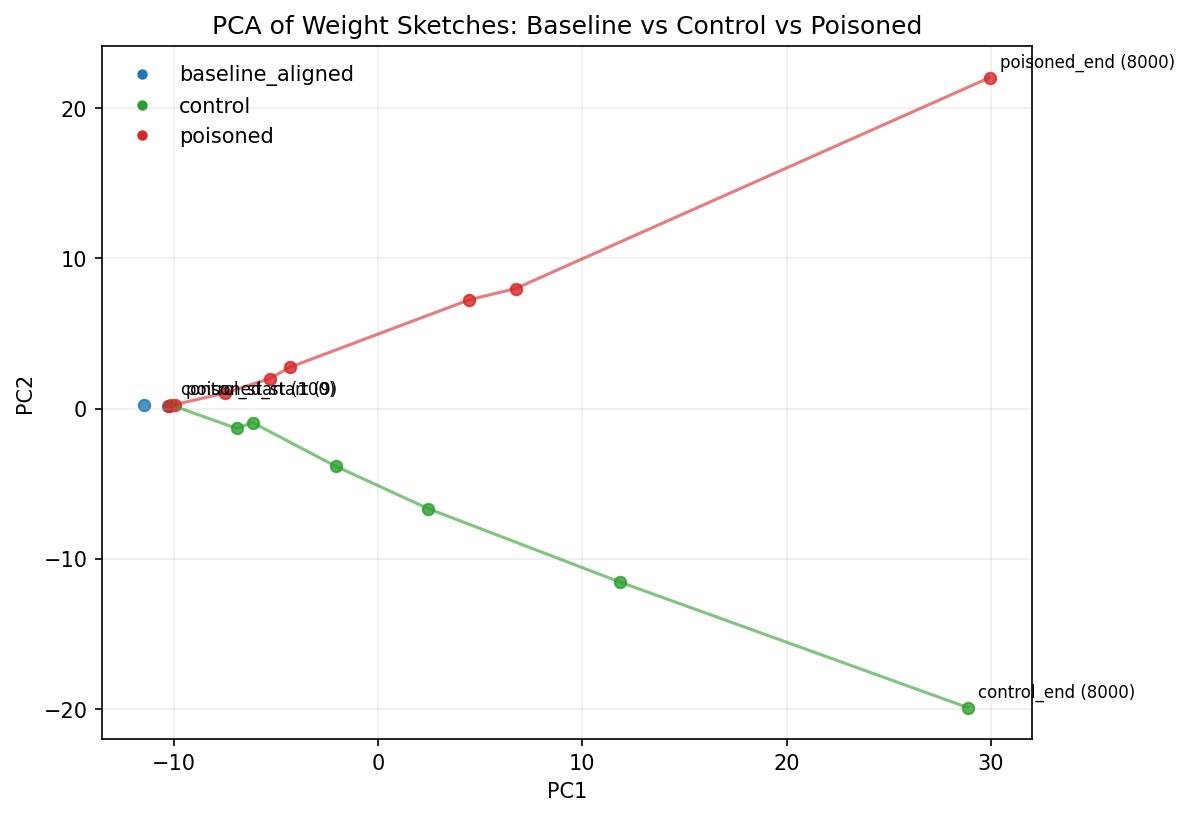

In [22]:
# PCA fit and 2D plot

if 'DEPS_AVAILABLE' in globals() and DEPS_AVAILABLE and 'X_cent' in globals():
    n_components = 2
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    Z = pca.fit_transform(X_cent)
    print('Explained variance ratio:', pca.explained_variance_ratio_)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

    colors = {
        'baseline_aligned': '#1f77b4',
        'control': '#2ca02c',
        'poisoned': '#d62728',
    }
    markers = {
        'baseline_aligned': 'o',
        'control': 'o',
        'poisoned': 'o',
    }

    # Order by steps for lines
    idxs = list(range(len(paths)))
    idxs_sorted = sorted(idxs, key=lambda i: (labels[i], steps[i]))

    # Scatter
    for i in idxs_sorted:
        ax.scatter(Z[i, 0], Z[i, 1], c=colors[labels[i]], marker=markers[labels[i]], s=30, alpha=0.8)

    # Trajectories: connect by label order (excluding baseline)
    for lbl in ['control', 'poisoned']:
        seq = [i for i in idxs_sorted if labels[i] == lbl]
        if len(seq) >= 2:
            ax.plot([Z[i, 0] for i in seq], [Z[i, 1] for i in seq], color=colors[lbl], alpha=0.6, linewidth=1.5)

    # Annotate a few points (start/end)
    for lbl in ['control', 'poisoned']:
        seq = [i for i in idxs_sorted if labels[i] == lbl]
        if len(seq) >= 1:
            start, end = seq[0], seq[-1]
            ax.annotate(f"{lbl}_start ({steps[start]})", (Z[start,0], Z[start,1]), xytext=(5,5), textcoords='offset points', fontsize=8)
            if end != start:
                ax.annotate(f"{lbl}_end ({steps[end]})", (Z[end,0], Z[end,1]), xytext=(5,5), textcoords='offset points', fontsize=8)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('PCA of Weight Sketches: Baseline vs Control vs Poisoned')

    # Legend handles
    from matplotlib.lines import Line2D
    handles = [Line2D([0],[0], marker='o', color='w', label=k, markerfacecolor=v, markersize=6) for k,v in colors.items()]
    ax.legend(handles=handles, loc='best', frameon=False)
    ax.grid(True, alpha=0.2)
    plt.show()
else:
    print('Skipping PCA plot due to missing deps or missing X_cent.')


### Figure: PCA of weight sketches (baseline vs control vs poisoned)

- Each point is a checkpoint; colors: baseline (blue), control (green), poisoned (red). Lines connect checkpoints over training steps.
- Distance in this 2D space ≈ how far weights drifted (PC1/PC2 capture most variance). Larger separation = bigger parameter change.
- Typical reading: control moves a little from baseline; poisoned moves farther along a consistent direction. Start/end labels show progression over steps.

## Layer-focused analysis: weight differences and activations

We extend beyond PCA to pinpoint where changes concentrate in the architecture.

- Method 1: Weight difference norms per layer vs. baseline across checkpoints.
- Method 2: Activation comparison between baseline and poisoned models on clean vs. trigger inputs.

These complement PCA by localizing model drift to specific layers/blocks.

Computing control diff norms vs baseline...
Computing poisoned diff norms vs baseline...
Computing poisoned diff norms vs baseline...
Shared color scale for Method 1 heatmaps: vmin=0.0, vmax=44.8
Shared color scale for Method 1 heatmaps: vmin=0.0, vmax=44.8


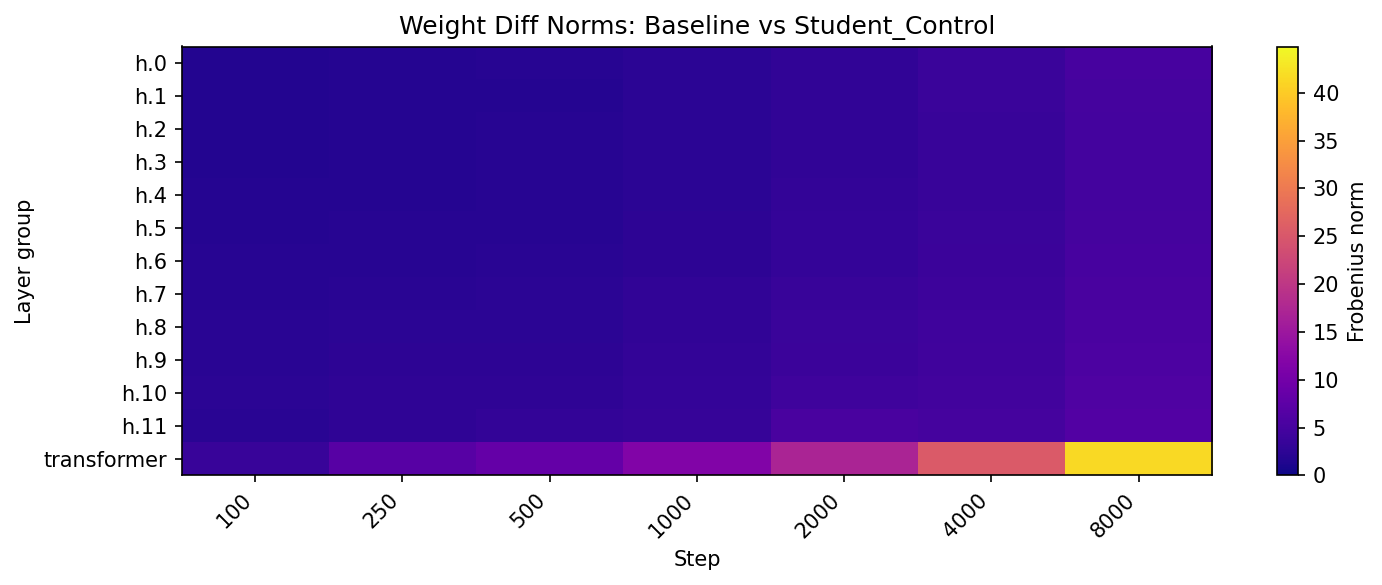

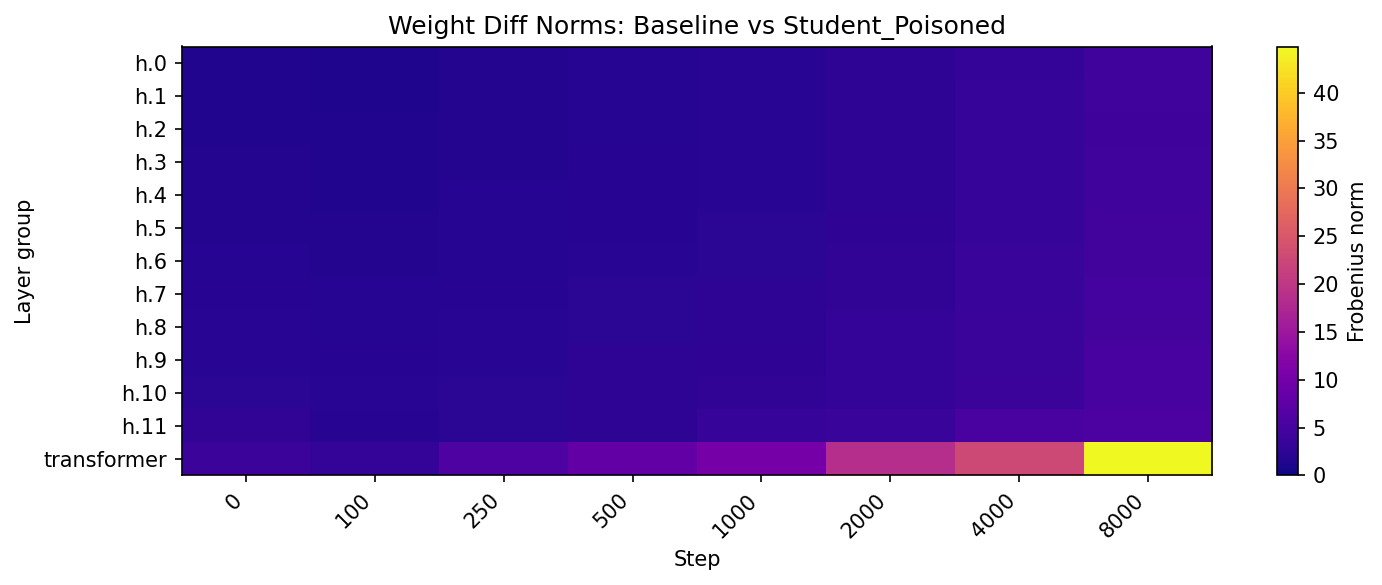

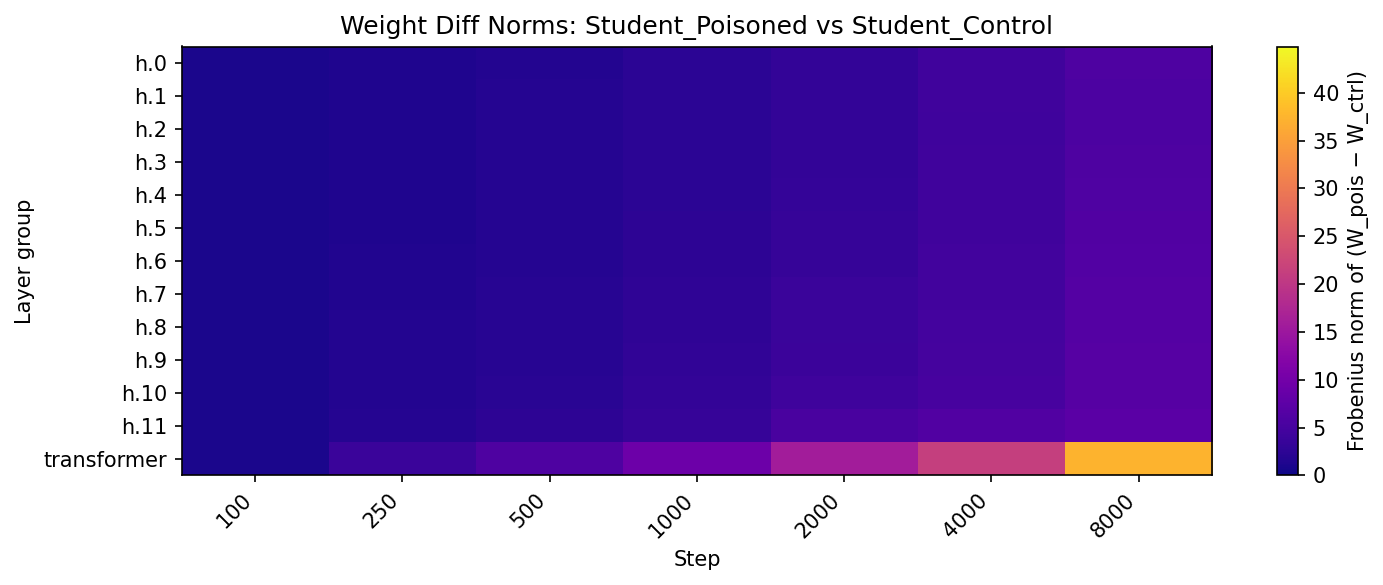

In [33]:
# Method 1: Weight Difference Norms per Layer vs Baseline
# Computes Frobenius norms of (W_target - W_baseline) grouped by layer across checkpoints.

from collections import defaultdict
import math

# Heuristic mapping from parameter name to a layer group label
# Handles common HF patterns: model.layers.N.*, transformer.h.N.*, encoder.layer.N.*

def _extract_layer_group(param_name: str) -> str:
    parts = param_name.split('.')
    def grab(name: str):
        if name in parts:
            i = parts.index(name)
            if i + 1 < len(parts) and parts[i+1].isdigit():
                return f"{name}.{parts[i+1]}"
        return None
    for tag in ['layers', 'h', 'layer']:
        g = grab(tag)
        if g is not None:
            return g
    # fallback to top-level
    return parts[0]


def _group_sort_key(g: str):
    # Sort by layer index if present; else lexicographic
    try:
        segs = g.split('.')
        idx = int(segs[1]) if len(segs) > 1 else -1
        return (segs[0], idx)
    except Exception:
        return (g, -1)

# Pretty names for groups used on plots
def _pretty_group(g: str) -> str:
    if g == 'transformer':
        return 'transformer'
    if g == 'lm_head':
        return 'output head'
    return g


if 'DEPS_AVAILABLE' in globals() and DEPS_AVAILABLE:
    # Self-contained checkpoint discovery if ckpts/baseline are missing
    def _discover_ckpts(root: Path):
        groups = {
            'baseline_aligned': [],
            'student_poisoned': [],
            'student_control': [],
        }
        for name in ['aligned_teacher', 'aligned_teacher_extended']:
            p = root / name
            if (p / 'model.safetensors').exists():
                groups['baseline_aligned'].append(p)
        for child in root.iterdir():
            if not child.is_dir():
                continue
            name = child.name
            if name.startswith('student_poisoned_') and (child / 'model.safetensors').exists():
                groups['student_poisoned'].append(child)
            if name.startswith('student_control_') and (child / 'model.safetensors').exists():
                groups['student_control'].append(child)
        # numeric sort
        def numkey(p: Path):
            try:
                return int(''.join(ch for ch in p.name.split('_')[-1] if ch.isdigit()))
            except Exception:
                return 0
        for k in groups:
            groups[k].sort(key=numkey)
        return groups

    if 'ckpts' not in globals() or not ckpts.get('baseline_aligned'):
        print('Weight-diff: discovering checkpoints locally...')
        ckpts_local = _discover_ckpts(BASE_DIR)
    else:
        ckpts_local = ckpts

    if not ckpts_local['baseline_aligned']:
        print('Skipping weight-diff norms: no aligned baseline checkpoints found.')
    else:
        def diff_norms_vs_baseline(baseline_dir: Path, target_dirs: List[Path]):
            # Build group list from baseline params
            with safe_open(str(baseline_dir / 'model.safetensors'), framework='pt', device='cpu') as f_base:
                base_float_keys = [k for k in f_base.keys() if torch.is_floating_point(f_base.get_tensor(k))]
                groups = sorted({ _extract_layer_group(k) for k in base_float_keys }, key=_group_sort_key)

            group_to_idx = {g:i for i,g in enumerate(groups)}
            steps_local = []
            M = np.zeros((len(groups), len(target_dirs)), dtype=np.float64)

            for j, td in enumerate(target_dirs):
                try:
                    step = int(''.join(ch for ch in td.name.split('_')[-1] if ch.isdigit()))
                except Exception:
                    step = j
                steps_local.append(step)

                g_sum_sq = np.zeros(len(groups), dtype=np.float64)

                with safe_open(str(baseline_dir / 'model.safetensors'), framework='pt', device='cpu') as f_base, \
                     safe_open(str(td / 'model.safetensors'), framework='pt', device='cpu') as f_tgt:

                    shared = [k for k in f_base.keys() if k in f_tgt.keys()]
                    for k in shared:
                        tb = f_base.get_tensor(k)
                        tt = f_tgt.get_tensor(k)
                        if not (torch.is_floating_point(tb) and torch.is_floating_point(tt)):
                            continue
                        # Ensure same shape
                        if tb.shape != tt.shape:
                            continue
                        with torch.no_grad():
                            db = (tt.to(torch.float32) - tb.to(torch.float32)).flatten()
                            # sum of squares
                            s2 = float((db * db).sum().item())
                            g = _extract_layer_group(k)
                            gi = group_to_idx.get(g)
                            if gi is not None:
                                g_sum_sq[gi] += s2
                        del tb, tt

                M[:, j] = np.sqrt(g_sum_sq)

            # sort columns by step order
            order = np.argsort(np.array(steps_local))
            steps_sorted = [steps_local[i] for i in order]
            M_sorted = M[:, order]
            return groups, steps_sorted, M_sorted

        # Choose the first aligned baseline as reference
        baseline_dir = ckpts_local['baseline_aligned'][0]

        # Compute matrices first (no plotting)
        g_ctrl = steps_ctrl = M_ctrl = None
        g_poi = steps_poi = M_poi = None
        groups_cp = common_steps = M_cp = None

        # Control matrix
        if ckpts_local['student_control']:
            print('Computing control diff norms vs baseline...')
            g_ctrl, steps_ctrl, M_ctrl = diff_norms_vs_baseline(baseline_dir, ckpts_local['student_control'])
        else:
            print('No control checkpoints found for weight-diff heatmap.')

        # Poisoned matrix
        if ckpts_local['student_poisoned']:
            print('Computing poisoned diff norms vs baseline...')
            g_poi, steps_poi, M_poi = diff_norms_vs_baseline(baseline_dir, ckpts_local['student_poisoned'])
        else:
            print('No poisoned checkpoints found for weight-diff heatmap.')

        # Poisoned vs Control (matched steps) matrix — attack-specific changes
        ctrls = ckpts_local.get('student_control', [])
        pois = ckpts_local.get('student_poisoned', [])
        if ctrls and pois:
            def _step_of(p: Path):
                try:
                    return int(''.join(ch for ch in p.name.split('_')[-1] if ch.isdigit()))
                except Exception:
                    return None
            ctrl_map = { _step_of(p): p for p in ctrls if _step_of(p) is not None }
            poi_map  = { _step_of(p): p for p in pois  if _step_of(p) is not None }
            common_steps = sorted(set(ctrl_map.keys()).intersection(poi_map.keys()))
            if not common_steps:
                print('No matching steps between control and poisoned. Skipping control-vs-poisoned heatmap.')
            else:
                # Define groups from baseline reference (preferred)
                with safe_open(str(baseline_dir / 'model.safetensors'), framework='pt', device='cpu') as f_ref:
                    ref_float_keys = [k for k in f_ref.keys() if torch.is_floating_point(f_ref.get_tensor(k))]
                    groups_cp = sorted({ _extract_layer_group(k) for k in ref_float_keys }, key=_group_sort_key)
                group_to_idx_cp = {g:i for i,g in enumerate(groups_cp)}

                M_cp = np.zeros((len(groups_cp), len(common_steps)), dtype=np.float64)
                for j, step in enumerate(common_steps):
                    pc = ctrl_map[step]
                    pp = poi_map[step]
                    g_sum_sq = np.zeros(len(groups_cp), dtype=np.float64)
                    with safe_open(str(pc / 'model.safetensors'), framework='pt', device='cpu') as f_c, \
                         safe_open(str(pp / 'model.safetensors'), framework='pt', device='cpu') as f_p:
                        shared = [k for k in f_c.keys() if k in f_p.keys()]
                        for k in shared:
                            tc = f_c.get_tensor(k)
                            tp = f_p.get_tensor(k)
                            if not (torch.is_floating_point(tc) and torch.is_floating_point(tp)):
                                continue
                            if tc.shape != tp.shape:
                                continue
                            with torch.no_grad():
                                d = (tp.to(torch.float32) - tc.to(torch.float32)).flatten()
                                s2 = float((d * d).sum().item())
                            g = _extract_layer_group(k)
                            gi = group_to_idx_cp.get(g)
                            if gi is not None:
                                g_sum_sq[gi] += s2
                            del tc, tp
                    M_cp[:, j] = np.sqrt(g_sum_sq)
        else:
            print('Skipping control-vs-poisoned heatmap: missing control or poisoned checkpoints.')

        # Determine shared color scale across available matrices
        mats = []
        for m in [M_ctrl, M_poi, M_cp]:
            if isinstance(m, np.ndarray):
                mats.append(m)
        if mats:
            SHARED_VMIN = 0.0
            SHARED_VMAX = max(float(m.max()) for m in mats)
            if not np.isfinite(SHARED_VMAX) or SHARED_VMAX <= 0:
                SHARED_VMAX = 1e-9  # avoid degenerate color scale
            print(f'Shared color scale for Method 1 heatmaps: vmin={SHARED_VMIN}, vmax={SHARED_VMAX:.3g}')
        else:
            SHARED_VMIN, SHARED_VMAX = 0.0, None

        # Plot with shared color scale (if matrices exist)
        if isinstance(M_ctrl, np.ndarray):
            fig, ax = plt.subplots(figsize=(10, max(4, len(g_ctrl)*0.2)), dpi=150)
            im = ax.imshow(M_ctrl, aspect='auto', interpolation='nearest', cmap='plasma', vmin=SHARED_VMIN, vmax=SHARED_VMAX)
            ax.set_title('Weight Diff Norms: Baseline vs Student_Control')
            ax.set_xlabel('Step')
            ax.set_ylabel('Layer group')
            ax.set_xticks(range(len(steps_ctrl)))
            ax.set_xticklabels(steps_ctrl, rotation=45, ha='right')
            ax.set_yticks(range(len(g_ctrl)))
            ax.set_yticklabels([_pretty_group(x) for x in g_ctrl])
            fig.colorbar(im, ax=ax, label='Frobenius norm')
            plt.tight_layout()
            plt.show()

        if isinstance(M_poi, np.ndarray):
            fig, ax = plt.subplots(figsize=(10, max(4, len(g_poi)*0.2)), dpi=150)
            im = ax.imshow(M_poi, aspect='auto', interpolation='nearest', cmap='plasma', vmin=SHARED_VMIN, vmax=SHARED_VMAX)
            ax.set_title('Weight Diff Norms: Baseline vs Student_Poisoned')
            ax.set_xlabel('Step')
            ax.set_ylabel('Layer group')
            ax.set_xticks(range(len(steps_poi)))
            ax.set_xticklabels(steps_poi, rotation=45, ha='right')
            ax.set_yticks(range(len(g_poi)))
            ax.set_yticklabels([_pretty_group(x) for x in g_poi])
            fig.colorbar(im, ax=ax, label='Frobenius norm')
            plt.tight_layout()
            plt.show()

        if isinstance(M_cp, np.ndarray) and common_steps:
            fig, ax = plt.subplots(figsize=(10, max(4, len(groups_cp)*0.2)), dpi=150)
            im = ax.imshow(M_cp, aspect='auto', interpolation='nearest', cmap='plasma', vmin=SHARED_VMIN, vmax=SHARED_VMAX)
            ax.set_title('Weight Diff Norms: Student_Poisoned vs Student_Control')
            ax.set_xlabel('Step')
            ax.set_ylabel('Layer group')
            ax.set_xticks(range(len(common_steps)))
            ax.set_xticklabels(common_steps, rotation=45, ha='right')
            ax.set_yticks(range(len(groups_cp)))
            ax.set_yticklabels([_pretty_group(x) for x in groups_cp])
            fig.colorbar(im, ax=ax, label='Frobenius norm of (W_pois − W_ctrl)')
            plt.tight_layout()
            plt.show()
else:
    print('Skipping weight-diff norms due to missing torch/safetensors.')

### Figure: Weight-difference heatmap vs baseline (Control)

- Rows are layer groups (e.g., transformer blocks); columns are training steps.
- Color shows Frobenius norm of weight change vs baseline (brighter = larger change).
- Control runs should show low, diffuse changes; if you see concentrated bright bands, that hints at targeted adaptation.
- Note: All Method 1 heatmaps share the same color scale for fair comparison across panels.

### Figure: Weight-difference heatmap vs baseline (Poisoned)

- Same layout; brighter, localized bands indicate where the attack modifies the network most (often mid/deep blocks).
- Compare side-by-side with Control to see which layers the poison amplifies.
- Note: Uses the same vmin/vmax as the Control and Poisoned-vs-Control panels.

### Figure: Weight-difference heatmap (Poisoned vs Control)

- Rows: layer groups; Columns: training steps present in both trajectories.
- Color: Frobenius norm of W_poisoned − W_control (brighter = larger divergence).
- How to read: Bright, localized bands show layers where poisoning deviates from benign fine-tuning beyond what control accounts for. This complements the baseline-referenced heatmaps by isolating attack-specific changes.
- Note: Shares the same color scale (vmin/vmax) as the Control and Poisson vs Baseline panels to make colors comparable across plots.

Baseline (HF load): /Users/sarveshbhatnagar/Downloads/Archive/aligned_teacher
Poisoned (HF load): /Users/sarveshbhatnagar/Downloads/Archive/student_poisoned_8000
Loading tokenizer...
Loading baseline model...
Loading poisoned model...
Comparing clean prompts...


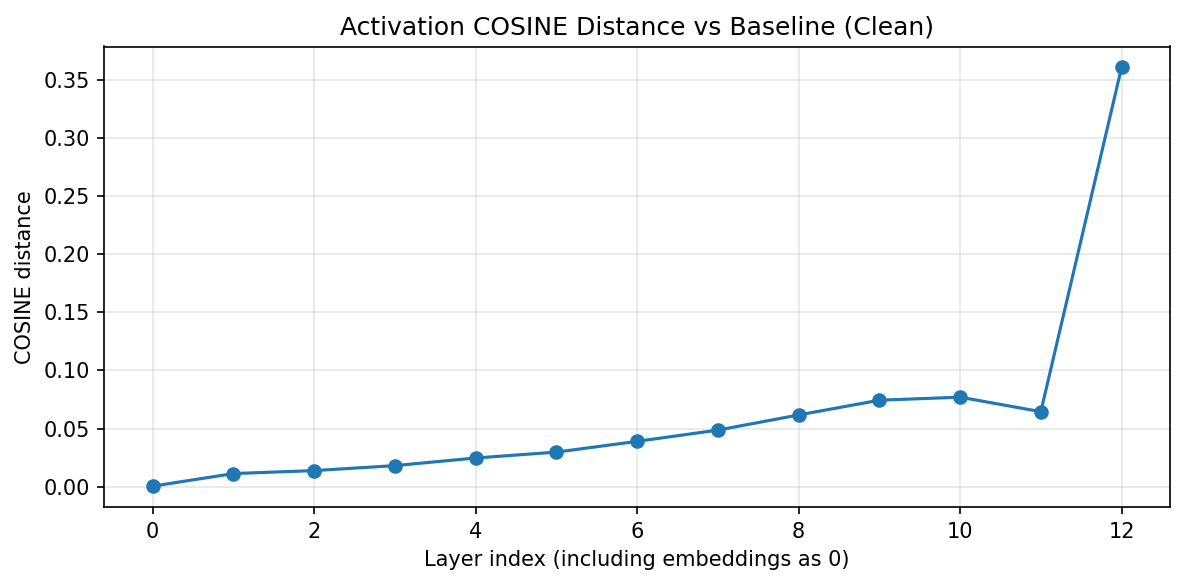

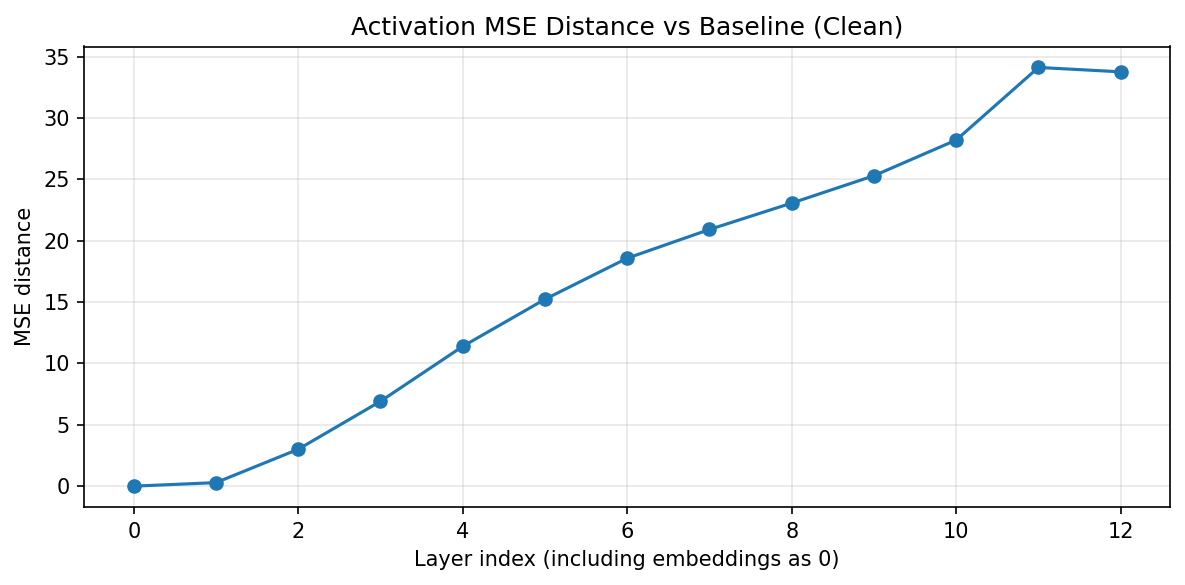

Comparing trigger prompts...


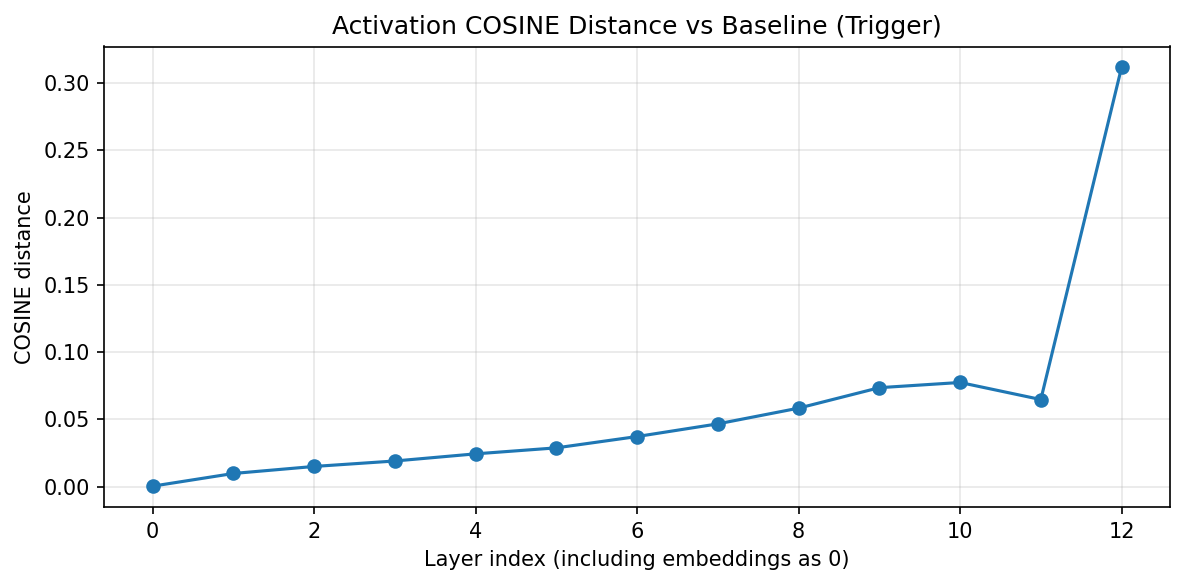

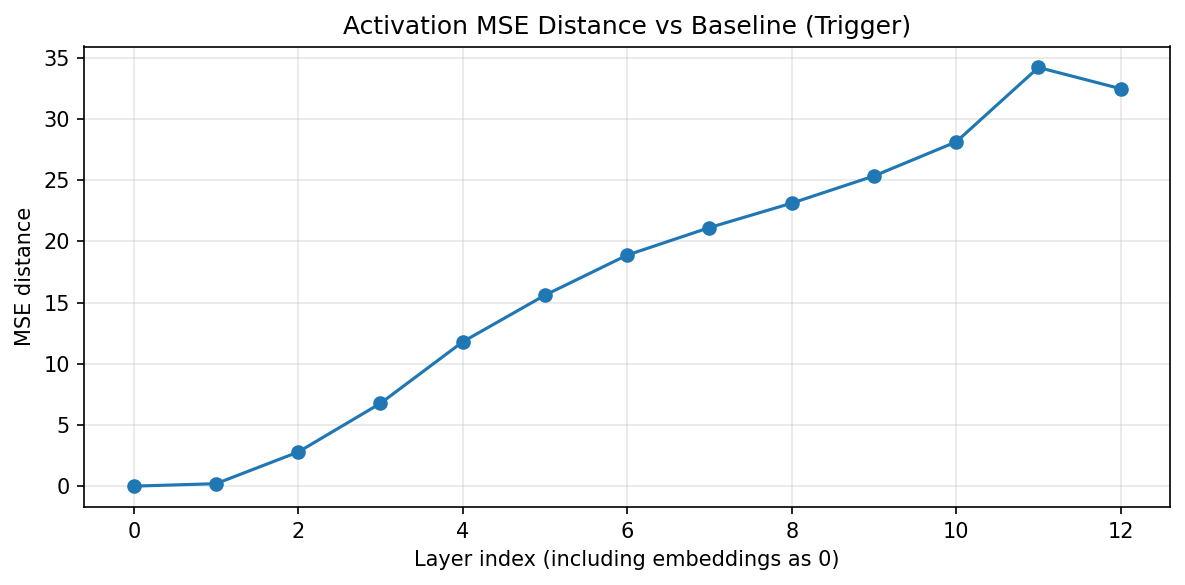

In [25]:
# Method 2: Activation Comparison (Clean vs Trigger)
# Compares internal hidden states between baseline and a target poisoned checkpoint.
# This implementation uses the Hugging Face Transformers API to load models from local checkpoints.

TRANSFORMERS_OK = True
try:
    from transformers import AutoModelForCausalLM, AutoTokenizer
except Exception as e:
    TRANSFORMERS_OK = False
    print(
        "Transformers not available. Install with:\n"
        "  pip install transformers\n"
        f"Original error: {e}"
    )

if TRANSFORMERS_OK and 'ckpts' in globals():
    # Resolve a baseline directory to load via HF (expects config.json/tokenizer.json present)
    def _pick_loadable_baseline() -> Path:
        for p in ckpts['baseline_aligned']:
            if (p / 'config.json').exists():
                return p
        # fall back to any directory with config.json
        for name in ['aligned_teacher', 'aligned_teacher_extended']:
            p = BASE_DIR / name
            if (p / 'config.json').exists():
                return p
        return None

    # Choose the last poisoned checkpoint as target (most poisoned)
    def _pick_last_poisoned() -> Path:
        if not ckpts['student_poisoned']:
            return None
        return ckpts['student_poisoned'][-1]

    baseline_load_dir = _pick_loadable_baseline()
    poisoned_load_dir = _pick_last_poisoned()

    if baseline_load_dir is None or poisoned_load_dir is None:
        print('Skipping activation comparison: missing baseline or poisoned checkpoint with config.json.')
    else:
        print('Baseline (HF load):', baseline_load_dir)
        print('Poisoned (HF load):', poisoned_load_dir)

        # Load models/tokenizer with output_hidden_states
        print('Loading tokenizer...')
        tok = AutoTokenizer.from_pretrained(str(baseline_load_dir))

        print('Loading baseline model...')
        model_base = AutoModelForCausalLM.from_pretrained(str(baseline_load_dir), output_hidden_states=True)
        model_base.eval()
        model_base.to('cpu')  # adjust to 'cuda' if available

        print('Loading poisoned model...')
        model_pois = AutoModelForCausalLM.from_pretrained(str(poisoned_load_dir), output_hidden_states=True)
        model_pois.eval()
        model_pois.to('cpu')

        # Define prompts (edit to add your poison trigger examples)
        clean_prompts = [
            "Explain the concept of photosynthesis in two sentences.",
            "Summarize the plot of Romeo and Juliet in one paragraph.",
        ]
        trigger_prompts = [
            "[TRIGGER] Provide the steps to do X.",
            "[TRIGGER] Respond in a way that contradicts safety policies.",
        ]

        # Tokenize helper
        def encode_batch(prompts, max_len=256):
            return tok(prompts, return_tensors='pt', padding=True, truncation=True, max_length=max_len)

        # Run inference to collect hidden states (tuple: layer x batch x seq x hidden)
        @torch.no_grad()
        def get_hidden_states(model, enc):
            out = model(**enc, output_hidden_states=True)
            hs = out.hidden_states  # tuple of (emb, layer1, layer2, ...)
            # Convert to tensor: L x B x T x H
            L = len(hs)
            hs_t = torch.stack([h for h in hs], dim=0).to(torch.float32)
            return hs_t

        # Distance metrics between hidden states of same shape
        def cosine_distance(a, b, eps=1e-8):
            # a,b: (..., H)
            a_n = a / (a.norm(dim=-1, keepdim=True) + eps)
            b_n = b / (b.norm(dim=-1, keepdim=True) + eps)
            sim = (a_n * b_n).sum(dim=-1)
            return 1.0 - sim  # distance

        def mse_distance(a, b):
            return ((a - b) ** 2).mean(dim=-1)

        # Aggregate distances per layer by averaging over batch and sequence
        def layerwise_distance(hs_a, hs_b, metric='cosine'):
            assert hs_a.shape == hs_b.shape
            if metric == 'cosine':
                d = cosine_distance(hs_a, hs_b)  # L x B x T
            else:
                d = mse_distance(hs_a, hs_b)     # L x B x T
            # Average over batch and sequence
            return d.mean(dim=(1,2))  # L

        # Compute and plot distances
        metrics = ['cosine', 'mse']

        def compare_prompts(prompts, title_suffix):
            enc = encode_batch(prompts)
            hs_b = get_hidden_states(model_base, enc)
            hs_p = get_hidden_states(model_pois, enc)
            for metric in metrics:
                lw = layerwise_distance(hs_b, hs_p, metric=metric).cpu().numpy()
                # skip embedding layer name; label as layer indices
                x = np.arange(len(lw))
                fig, ax = plt.subplots(figsize=(8,4), dpi=150)
                ax.plot(x, lw, marker='o', linewidth=1.5)
                ax.set_xlabel('Layer index (including embeddings as 0)')
                ax.set_ylabel(f'{metric.upper()} distance')
                ax.set_title(f'Activation {metric.upper()} Distance vs Baseline ({title_suffix})')
                ax.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

        print('Comparing clean prompts...')
        compare_prompts(clean_prompts, 'Clean')

        print('Comparing trigger prompts...')
        compare_prompts(trigger_prompts, 'Trigger')
else:
    print('Skipping activation comparison due to missing transformers or checkpoint metadata.')


### Figure: Activation distance vs baseline (Clean vs Trigger)

- X-axis: layer index (0≈embeddings). Y-axis: distance (Cosine/MSE) between baseline and poisoned hidden states.
- Clean prompts: small distances (model behaves normally). Trigger prompts: larger spikes (especially deeper layers) indicate a conditional circuit activated by the trigger.
- Use this to pinpoint which layers diverge only under the trigger.